# Multi-Layered Perceptron

The class Multi_layer_perceptron() implements a feed-forward multi-layered perceptron using logistic activation function along with an error back propagation system to adjust the weights of the model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# The random seed was set for testing, it can be commented for a different initialization of weights.
np.random.seed(67)

X is the input array of shape (16,4) and contains all possible inputs for a 4-bit value. Y is the output array of shape (16,1) and contains the actual output that a parity checker would return for the corresponding value of X.

In [2]:
X = np.array([[0,0,0,0],
              [0,0,0,1],
              [0,0,1,0],
              [0,0,1,1],
              [0,1,0,0],
              [0,1,0,1],
              [0,1,1,0],
              [0,1,1,1],
              [1,0,0,0],
              [1,0,0,1],
              [1,0,1,0],
              [1,0,1,1],
              [1,1,0,0],
              [1,1,0,1],
              [1,1,1,0],
              [1,1,1,1]
             ])
Y = np.array([[0],[1],[1],[0],[1],[0],[0],[1],[1],[0],[0],[1],[0],[1],[1],[0]])

The class below defines the entire model, activation function, feed-forward, bakc propagation and stochastic descent methods.

In [3]:
class Multi_layer_perceptron():
    def __init__(self):        
        self.eta = 0.5
        self.alpha = 0.0
        self.preNewFirstWeight = None
        self.preNewSecondWeight = None
        
    # The weights are initialized including the bias for each layer.
    def initialize_weights(self):
        self.firstWeight = np.random.uniform(-1, 1, (5, 4))
        self.secondWeight = np.random.uniform(-1, 1, (5, 1))

    # The activation function, in this case this is a sigmoid (logistic) function.
    def activation_function(self, x):
        return 1/ (1 + np.exp(-x))

    # Derivative for logistic activation function, this is used in the error-back propagation (learning) implementation.
    def derivative_function(self, x):
        return self.activation_function(x) * (1 - self.activation_function(x))

    # This function calculates the output of the layer
    def matrixFunction(self, input, func):
        row, col = input.shape
        result = np.zeros((row, col))
        for i in range(row):
            for j in range(col):
                result[i][j] = func(input[i][j])
        return result

    # This function adds a bias to the current array.
    def add_bias(self, input):
        row,col = input.shape
        bias = np.zeros((row, 1))
        for i in range(row):
            bias[i][0] = 1
        return np.concatenate((bias, input), axis = 1)
    
    # This is the main training function, this includes feed-forward and back propagation.
    def training(self, input, output):
        
        # First we add bias to our input 
        firstInput = self.add_bias(input)

        # Find output of first layer
        firstDot = np.dot(firstInput, self.firstWeight)
        firstY = self.matrixFunction(firstDot, self.activation_function)
        
        # We add bias to the output of first layer.
        secondInput = self.add_bias(firstY)
        
        # Find output of second layer
        secondDot = np.dot(secondInput, self.secondWeight)
        secondY = self.matrixFunction(secondDot, self.activation_function)
        
        # Calculate error
        secondDiff = output - secondY
        if abs(secondDiff) < 0.05:
            return secondDiff

        # Now, we implement error back propagation and update weights.
        secondDelta = self.matrixFunction(secondDot, self.derivative_function) * secondDiff
        newSecondWeight = (self.learningRate * np.dot(secondDelta, secondInput)).T
        secondWeightNoBias = self.secondWeight[1:, 0:1]

        firstDiff = np.dot(secondWeightNoBias, secondDelta)
        firstDelta = self.matrixFunction(firstDot, self.derivative_function).T * firstDiff
        newFirstWeight = (self.learningRate * np.dot(firstDelta, firstInput)).T

        # Update weights with momentum
        if self.preNewFirstWeight is not None and self.preNewSecondWeight is not None:
            newFirstWeight = self.momentum * self.preNewFirstWeight + newFirstWeight
            newSecondWeight = self.momentum * self.preNewSecondWeight + newSecondWeight

        self.preNewFirstWeight = newFirstWeight
        self.preNewSecondWeight = newSecondWeight
        self.firstWeight = self.firstWeight + newFirstWeight
        self.secondWeight = self.secondWeight + newSecondWeight
        return secondDiff

    # This function checks if the condition for termination is reached
    def trainingCompleted(self, input, desiredOutput):
        inputRow, inputCol = input.shape
        for i in range(inputRow):
            predicted, diff = self.getOutputDiff(np.reshape(input[i], (1, len(input[i]))), np.reshape(desiredOutput[i], (1, len(desiredOutput[i]))))
            if abs(diff) > 0.05:
                return False
        return True

    # This function calculates the difference between input and output
    def getOutputDiff(self, input, output):
        firstInput = self.add_bias(input)
        firstDot = np.dot(firstInput, self.firstWeight)
        firstY = self.matrixFunction(firstDot, self.activation_function)

        secondInput = self.add_bias(firstY)
        secondDot = np.dot(secondInput, self.secondWeight)
        secondY = self.matrixFunction(secondDot, self.activation_function)
        return secondY, abs(output - secondY)
    
    # This function resets weights so that a new model can be trained.
    def cleanup(self):
        self.preNewFirstWeight = None
        self.preNewSecondWeight = None
        
    # This is the main function, we call this with different learning rate and momentum
    def run(self, X, Y,learningRate, momentum = 0.0):
        print("Learning Rate : ", learningRate)
        print("Momentum : ", momentum)
        self.initialize_weights()
        self.cleanup()
        self.learningRate = learningRate
        self.momentum = momentum
        learningRate = learningRate
        momentum = momentum
        epochs = 0
        loss_per_epoch = []
        while True:
            completed = False
            total_loss = 0
            for j in range (len(X)):
                curInput = np.reshape(X[j], (1, len(X[j])))
                curOutput = Y[j]
                diff = self.training(curInput, curOutput)
                total_loss += np.abs(np.squeeze(diff))
                if self.trainingCompleted(X, Y):
                    completed = True
                    break
            epochs += 1
            loss = 0.5 * total_loss / 16
            loss_per_epoch.append(loss)
            if epochs % 2000 == 0:
                print(f"Epochs reach = {epochs} with loss = {loss}")
            # The loop stops if the epochs are over 100,000. this is added just to avoid infinite loop condition.
            if epochs >= 500000:
                completed = True
            if completed:
                break
        print("Epochs required to converge = ", epochs)
        plt.plot(loss_per_epoch)
        plt.ylabel("errors")
        plt.xlabel("epoch")
        plt.show()
        return epochs
        

In [4]:
model = Multi_layer_perceptron()
# model.run(X, Y, 0.5, 0.0)

<b>Question 1.</b> Vary the value of learning rate from 0.05 to 0.5 using an increment of 0.05, and report the number of epochs for each choice of learning rate. Also generate learning curve plots for each case. Discuss how the value of learning rate influences convergence.

<b>Ans.</b> The plots for each value of learning rate is plotted below. From the epoch values we can observe that the model converges very slowly when the learning rate is too low or when the learning rate is too high. This proves that when the learning rate is too low, the updates are so small that it takes many iterations or epochs to converge the model. Also, when the learning rate is too high, the model does not converge as the updates are too big for the error to consistently decrease. When the learning rate is 0.20, the model converges in 25,921 epochs which is the fastest of all the learning rates tested. For learning rate 0.05 the model did not converge entirely, the code was stopped at 500,000 epochs so that it gets a stable exit condition as it might've been possible that the code would not converge to loss less than 0.05. 

In [5]:
df = pd.DataFrame({
    'Learning Rate' : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
})

Learning Rate :  0.05
Momentum :  0.0
Epochs reach = 2000 with loss = 0.25071380068282156
Epochs reach = 4000 with loss = 0.2506504747209977
Epochs reach = 6000 with loss = 0.2505758724558211
Epochs reach = 8000 with loss = 0.2504403985018649
Epochs reach = 10000 with loss = 0.2497104517567783
Epochs reach = 12000 with loss = 0.22155650191425622
Epochs reach = 14000 with loss = 0.12391446507778102
Epochs reach = 16000 with loss = 0.08904091256208958
Epochs reach = 18000 with loss = 0.0783981119011007
Epochs reach = 20000 with loss = 0.07376982968186248
Epochs reach = 22000 with loss = 0.07061717300102714
Epochs reach = 24000 with loss = 0.0684643909597904
Epochs reach = 26000 with loss = 0.06719192101118099
Epochs reach = 28000 with loss = 0.06665103753285964
Epochs reach = 30000 with loss = 0.06646043564088144
Epochs reach = 32000 with loss = 0.06640663566666674
Epochs reach = 34000 with loss = 0.06636760643760493
Epochs reach = 36000 with loss = 0.06634033400121607
Epochs reach = 380

Epochs reach = 308000 with loss = 0.06715410216289945
Epochs reach = 310000 with loss = 0.0671560805345414
Epochs reach = 312000 with loss = 0.06714861642772223
Epochs reach = 314000 with loss = 0.06714736574938035
Epochs reach = 316000 with loss = 0.06714562588234993
Epochs reach = 318000 with loss = 0.06714448598304733
Epochs reach = 320000 with loss = 0.06714051611099031
Epochs reach = 322000 with loss = 0.06714249546594692
Epochs reach = 324000 with loss = 0.06713420067209865
Epochs reach = 326000 with loss = 0.06713223759914745
Epochs reach = 328000 with loss = 0.06713425617326857
Epochs reach = 330000 with loss = 0.06712873161384897
Epochs reach = 332000 with loss = 0.06712254122056704
Epochs reach = 334000 with loss = 0.06712295294306271
Epochs reach = 336000 with loss = 0.06711560824308178
Epochs reach = 338000 with loss = 0.06711925084102399
Epochs reach = 340000 with loss = 0.06711246318382842
Epochs reach = 342000 with loss = 0.06711445219224056
Epochs reach = 344000 with lo

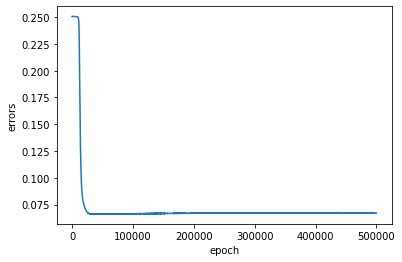

--------------------------------------------------
Learning Rate :  0.1
Momentum :  0.0
Epochs reach = 2000 with loss = 0.2514098497667342
Epochs reach = 4000 with loss = 0.24392393005208723
Epochs reach = 6000 with loss = 0.10337195401350262
Epochs reach = 8000 with loss = 0.07618975329005402
Epochs reach = 10000 with loss = 0.06881051478432094
Epochs reach = 12000 with loss = 0.06769843087807699
Epochs reach = 14000 with loss = 0.0673372217666116
Epochs reach = 16000 with loss = 0.0672905595451523
Epochs reach = 18000 with loss = 0.0672493050653639
Epochs reach = 20000 with loss = 0.06724983341074339
Epochs reach = 22000 with loss = 0.06721629842063417
Epochs reach = 24000 with loss = 0.06720391355620788
Epochs reach = 26000 with loss = 0.06718486684436072
Epochs reach = 28000 with loss = 0.06716619879059217
Epochs reach = 30000 with loss = 0.06716469383891013
Epochs reach = 32000 with loss = 0.06714866787126815
Epochs reach = 34000 with loss = 0.06712381346789702
Epochs reach = 3600

Epochs reach = 306000 with loss = 0.06694544246396779
Epochs reach = 308000 with loss = 0.06694313762102497
Epochs reach = 310000 with loss = 0.06693781997849432
Epochs reach = 312000 with loss = 0.06693950670591291
Epochs reach = 314000 with loss = 0.06694581045070759
Epochs reach = 316000 with loss = 0.06695120470123428
Epochs reach = 318000 with loss = 0.0669423392058699
Epochs reach = 320000 with loss = 0.06695716233957592
Epochs reach = 322000 with loss = 0.06694059792494349
Epochs reach = 324000 with loss = 0.0669575486144507
Epochs reach = 326000 with loss = 0.06693339531143488
Epochs reach = 328000 with loss = 0.06694222414533656
Epochs reach = 330000 with loss = 0.06695749391152196
Epochs reach = 332000 with loss = 0.06694051059568486
Epochs reach = 334000 with loss = 0.06695686736428778
Epochs reach = 336000 with loss = 0.06693574167627257
Epochs reach = 338000 with loss = 0.06692046789911944
Epochs reach = 340000 with loss = 0.06693468245722102
Epochs reach = 342000 with los

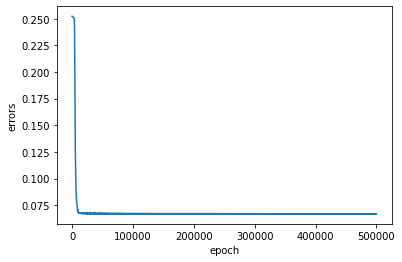

--------------------------------------------------
Learning Rate :  0.15
Momentum :  0.0
Epochs reach = 2000 with loss = 0.2516278355939612
Epochs reach = 4000 with loss = 0.25137726916516057
Epochs reach = 6000 with loss = 0.25070582429493454
Epochs reach = 8000 with loss = 0.08841351370819413
Epochs reach = 10000 with loss = 0.06813869360696838
Epochs reach = 12000 with loss = 0.06390642924619022
Epochs reach = 14000 with loss = 0.06273475038137852
Epochs reach = 16000 with loss = 0.06255229072551596
Epochs reach = 18000 with loss = 0.06243095258885723
Epochs reach = 20000 with loss = 0.06237977868504943
Epochs reach = 22000 with loss = 0.06232845778202366
Epochs reach = 24000 with loss = 0.062297253715979335
Epochs reach = 26000 with loss = 0.06225609798138032
Epochs reach = 28000 with loss = 0.06226224733007746
Epochs reach = 30000 with loss = 0.06222675034964131
Epochs reach = 32000 with loss = 0.06221512006771955
Epochs reach = 34000 with loss = 0.06219779976080493
Epochs reach =

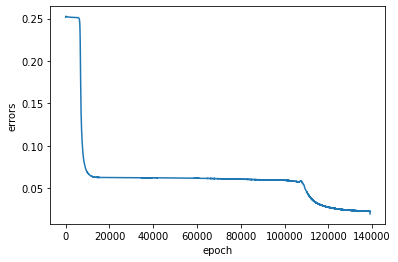

--------------------------------------------------
Learning Rate :  0.2
Momentum :  0.0
Epochs reach = 2000 with loss = 0.2517923580686378
Epochs reach = 4000 with loss = 0.2514659225357886
Epochs reach = 6000 with loss = 0.23572604611555784
Epochs reach = 8000 with loss = 0.08355439690474063
Epochs reach = 10000 with loss = 0.06783941882895617
Epochs reach = 12000 with loss = 0.06749600505004992
Epochs reach = 14000 with loss = 0.0673727459631557
Epochs reach = 16000 with loss = 0.06731658384761652
Epochs reach = 18000 with loss = 0.06728471228383631
Epochs reach = 20000 with loss = 0.06643656477129231
Epochs reach = 22000 with loss = 0.03128876035361938
Epochs reach = 24000 with loss = 0.02177641508824842
Epochs required to converge =  25921


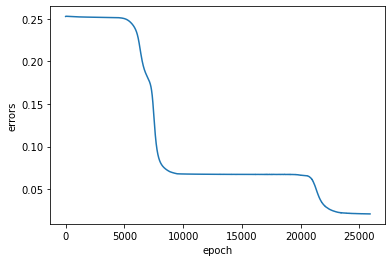

--------------------------------------------------
Learning Rate :  0.25
Momentum :  0.0
Epochs reach = 2000 with loss = 0.25219891432434843
Epochs reach = 4000 with loss = 0.25207066243633375
Epochs reach = 6000 with loss = 0.25202891722184434
Epochs reach = 8000 with loss = 0.251941842337028
Epochs reach = 10000 with loss = 0.24087527427019256
Epochs reach = 12000 with loss = 0.17148849842168706
Epochs reach = 14000 with loss = 0.0718667990037806
Epochs reach = 16000 with loss = 0.06713438994648666
Epochs reach = 18000 with loss = 0.06708170648277606
Epochs reach = 20000 with loss = 0.06708391038956733
Epochs reach = 22000 with loss = 0.0671144255290422
Epochs reach = 24000 with loss = 0.06715618941491547
Epochs reach = 26000 with loss = 0.06715843542273499
Epochs reach = 28000 with loss = 0.06717034334068382
Epochs reach = 30000 with loss = 0.06716802553319161
Epochs reach = 32000 with loss = 0.06715880346655505
Epochs reach = 34000 with loss = 0.06715751662133615
Epochs reach = 360

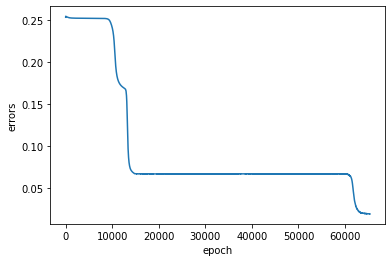

--------------------------------------------------
Learning Rate :  0.3
Momentum :  0.0
Epochs reach = 2000 with loss = 0.252559809081647
Epochs reach = 4000 with loss = 0.25244031623912
Epochs reach = 6000 with loss = 0.2524025514671861
Epochs reach = 8000 with loss = 0.25237704465161936
Epochs reach = 10000 with loss = 0.25227460544619407
Epochs reach = 12000 with loss = 0.22137084348095726
Epochs reach = 14000 with loss = 0.06965867920378493
Epochs reach = 16000 with loss = 0.06731575364015244
Epochs reach = 18000 with loss = 0.06721363239308363
Epochs reach = 20000 with loss = 0.06715629180317749
Epochs reach = 22000 with loss = 0.0671281585351747
Epochs reach = 24000 with loss = 0.06711221254192845
Epochs reach = 26000 with loss = 0.0670223549385414
Epochs reach = 28000 with loss = 0.06341982935047655
Epochs reach = 30000 with loss = 0.01977162017541149
Epochs required to converge =  31092


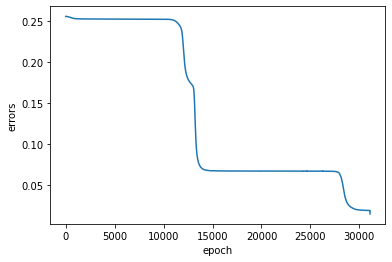

--------------------------------------------------
Learning Rate :  0.35
Momentum :  0.0
Epochs reach = 2000 with loss = 0.17751822233744016
Epochs reach = 4000 with loss = 0.06744423057307278
Epochs reach = 6000 with loss = 0.06720224389447786
Epochs reach = 8000 with loss = 0.06712005418348858
Epochs reach = 10000 with loss = 0.06708555860514387
Epochs reach = 12000 with loss = 0.06706977880748728
Epochs reach = 14000 with loss = 0.06708640205641767
Epochs reach = 16000 with loss = 0.06703308075497828
Epochs reach = 18000 with loss = 0.06705025658464342
Epochs reach = 20000 with loss = 0.06700914892546986
Epochs reach = 22000 with loss = 0.06705092840954252
Epochs reach = 24000 with loss = 0.06700935655520356
Epochs reach = 26000 with loss = 0.0670468108774607
Epochs reach = 28000 with loss = 0.06699592132269683
Epochs reach = 30000 with loss = 0.06695652413223988
Epochs reach = 32000 with loss = 0.06699744280697967
Epochs reach = 34000 with loss = 0.06702902355036122
Epochs reach = 

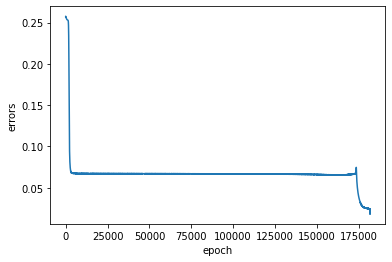

--------------------------------------------------
Learning Rate :  0.4
Momentum :  0.0
Epochs reach = 2000 with loss = 0.2532850745576407
Epochs reach = 4000 with loss = 0.16559728672438415
Epochs reach = 6000 with loss = 0.06752262667539649
Epochs reach = 8000 with loss = 0.06729129927944665
Epochs reach = 10000 with loss = 0.06718226227067184
Epochs reach = 12000 with loss = 0.06712599784419634
Epochs reach = 14000 with loss = 0.06709978983694506
Epochs reach = 16000 with loss = 0.06709641896554026
Epochs reach = 18000 with loss = 0.0670931380601697
Epochs reach = 20000 with loss = 0.06710998298039825
Epochs reach = 22000 with loss = 0.06703443498962496
Epochs reach = 24000 with loss = 0.06704255163289101
Epochs reach = 26000 with loss = 0.06702680214237132
Epochs reach = 28000 with loss = 0.06705646530515219
Epochs reach = 30000 with loss = 0.06703335759888852
Epochs reach = 32000 with loss = 0.06702752651591948
Epochs reach = 34000 with loss = 0.0669713828841973
Epochs reach = 360

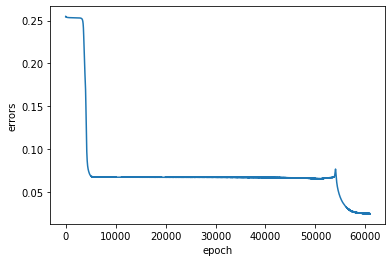

--------------------------------------------------
Learning Rate :  0.45
Momentum :  0.0
Epochs reach = 2000 with loss = 0.2536170182270405
Epochs reach = 4000 with loss = 0.25356043848442356
Epochs reach = 6000 with loss = 0.25339890648702657
Epochs reach = 8000 with loss = 0.17547915472239772
Epochs reach = 10000 with loss = 0.06730523042438319
Epochs reach = 12000 with loss = 0.0667484733510267
Epochs reach = 14000 with loss = 0.06673057877080033
Epochs reach = 16000 with loss = 0.06672305511415497
Epochs reach = 18000 with loss = 0.06679346032953165
Epochs reach = 20000 with loss = 0.06673698634507313
Epochs reach = 22000 with loss = 0.06673864470289478
Epochs reach = 24000 with loss = 0.06683915560039835
Epochs reach = 26000 with loss = 0.06677053865938669
Epochs reach = 28000 with loss = 0.06681422771170674
Epochs reach = 30000 with loss = 0.06678772267393807
Epochs reach = 32000 with loss = 0.0668880629040497
Epochs reach = 34000 with loss = 0.0668467200331064
Epochs reach = 360

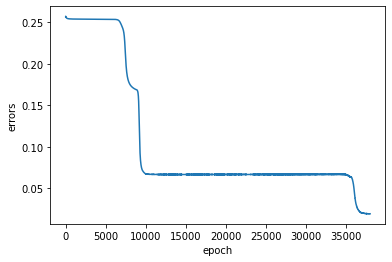

--------------------------------------------------
Learning Rate :  0.5
Momentum :  0.0
Epochs reach = 2000 with loss = 0.07237759830073566
Epochs reach = 4000 with loss = 0.0675132204999282
Epochs reach = 6000 with loss = 0.0673146525181431
Epochs reach = 8000 with loss = 0.06724376490378667
Epochs reach = 10000 with loss = 0.06715423477729388
Epochs reach = 12000 with loss = 0.06714627577254936
Epochs reach = 14000 with loss = 0.06713767387213009
Epochs reach = 16000 with loss = 0.06704152735490129
Epochs reach = 18000 with loss = 0.06704440138221142
Epochs reach = 20000 with loss = 0.0669989863092951
Epochs reach = 22000 with loss = 0.06705861311328581
Epochs reach = 24000 with loss = 0.06703918937523451
Epochs reach = 26000 with loss = 0.06701105990403797
Epochs reach = 28000 with loss = 0.06694394525380448
Epochs reach = 30000 with loss = 0.06696283208878287
Epochs reach = 32000 with loss = 0.06690960044896871
Epochs reach = 34000 with loss = 0.06689333055398966
Epochs reach = 360

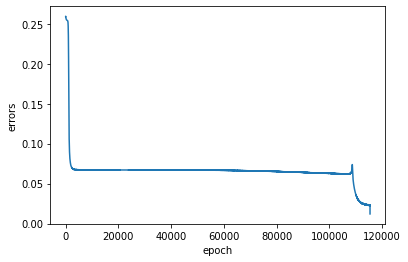

--------------------------------------------------


In [6]:
zero_momentum = []
for eta in df['Learning Rate']:
    total_epochs = model.run(X, Y, eta, 0.0)
    zero_momentum.append(total_epochs)
    print("-"*50)
df['Epochs for momentum 0'] = zero_momentum

<b>Question 2.</b> Include a momentum term in the weight update with momentum = 0.9 and report its effect on the speed of training for each value of learning rate.

<b>Ans.</b> When we introduce momentum to the model, we can observe that the number of epochs for the same value of learning rate decreases drastically. We observe that the introduction of momentum to the model allows the attenuation of oscillations in the stochastic gradient descent. From the data, the learning rate of 0.25 converges most quickly in 1,511 epochs, and the learning rate of 0.35 converges most slowly in 43,203 epochs. Even in the worst case of learning rate, the model converges rather than oscillating indefinitely or taking too small of steps to converge. This shows that if implemented correctly, momentum can speed up the training process draastically.

Learning Rate :  0.05
Momentum :  0.9
Epochs reach = 2000 with loss = 0.03166575182726426
Epochs required to converge =  3103


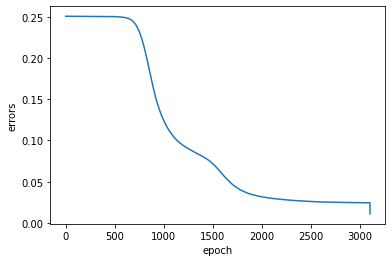

--------------------------------------------------
Learning Rate :  0.1
Momentum :  0.9
Epochs reach = 2000 with loss = 0.2508925702420616
Epochs reach = 4000 with loss = 0.2508532988370802
Epochs reach = 6000 with loss = 0.24927484764752156
Epochs reach = 8000 with loss = 0.06731867087742946
Epochs reach = 10000 with loss = 0.06706250617005415
Epochs reach = 12000 with loss = 0.06698829401475549
Epochs required to converge =  13300


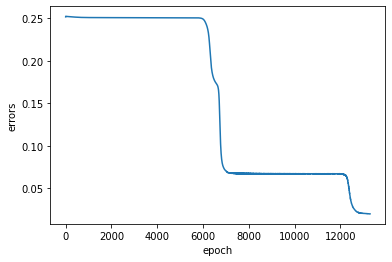

--------------------------------------------------
Learning Rate :  0.15
Momentum :  0.9
Epochs reach = 2000 with loss = 0.06718319908950254
Epochs reach = 4000 with loss = 0.020868121936313037
Epochs required to converge =  4185


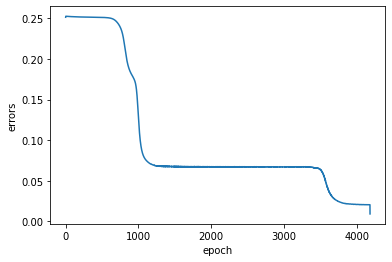

--------------------------------------------------
Learning Rate :  0.2
Momentum :  0.9
Epochs reach = 2000 with loss = 0.24866530389157737
Epochs reach = 4000 with loss = 0.06661259023276939
Epochs reach = 6000 with loss = 0.06673137734133791
Epochs required to converge =  6961


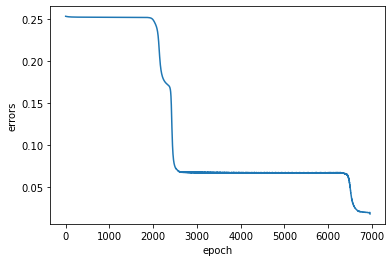

--------------------------------------------------
Learning Rate :  0.25
Momentum :  0.9
Epochs required to converge =  1511


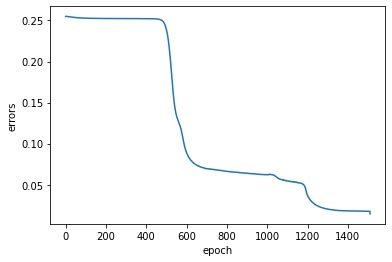

--------------------------------------------------
Learning Rate :  0.3
Momentum :  0.9
Epochs reach = 2000 with loss = 0.06652766337165608
Epochs reach = 4000 with loss = 0.06643338882032018
Epochs required to converge =  5070


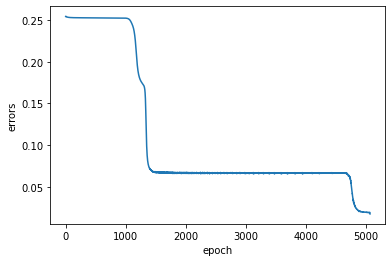

--------------------------------------------------
Learning Rate :  0.35
Momentum :  0.9
Epochs reach = 2000 with loss = 0.0666089426474185
Epochs reach = 4000 with loss = 0.06656422234133899
Epochs reach = 6000 with loss = 0.0666031523072274
Epochs reach = 8000 with loss = 0.06635314080500275
Epochs reach = 10000 with loss = 0.06626515730842927
Epochs reach = 12000 with loss = 0.06641582957873823
Epochs reach = 14000 with loss = 0.0658431701386755
Epochs reach = 16000 with loss = 0.06590888298812922
Epochs reach = 18000 with loss = 0.06612850857701111
Epochs reach = 20000 with loss = 0.06613765590226657
Epochs reach = 22000 with loss = 0.06553280483726298
Epochs reach = 24000 with loss = 0.06593063388680666
Epochs reach = 26000 with loss = 0.06517203559146562
Epochs reach = 28000 with loss = 0.06522581791030418
Epochs reach = 30000 with loss = 0.06527005128433688
Epochs reach = 32000 with loss = 0.06448023597206391
Epochs reach = 34000 with loss = 0.06498124319146416
Epochs reach = 36

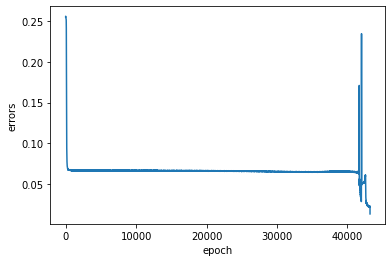

--------------------------------------------------
Learning Rate :  0.4
Momentum :  0.9
Epochs reach = 2000 with loss = 0.06652110943297714
Epochs reach = 4000 with loss = 0.06584026100213379
Epochs reach = 6000 with loss = 0.06604663215615719
Epochs reach = 8000 with loss = 0.22224547243808132
Epochs required to converge =  8442


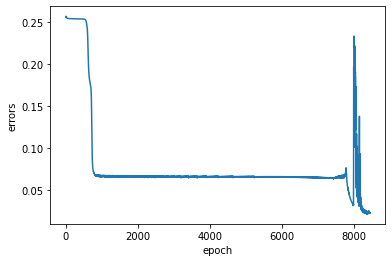

--------------------------------------------------
Learning Rate :  0.45
Momentum :  0.9
Epochs required to converge =  1932


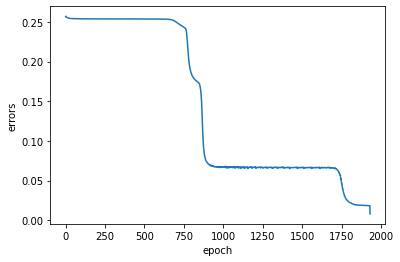

--------------------------------------------------
Learning Rate :  0.5
Momentum :  0.9
Epochs reach = 2000 with loss = 0.019395221374149365
Epochs required to converge =  2056


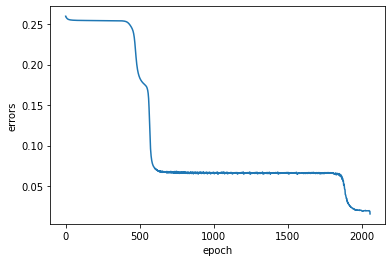

--------------------------------------------------


In [7]:
high_momentum = []
for eta in df['Learning Rate']:
    total_epochs = model.run(X, Y, eta, 0.9)
    high_momentum.append(total_epochs)
    print("-"*50)
df['Epochs for momentum 0.9'] = high_momentum

In [8]:
df

,Learning Rate,Epochs for momentum 0,Epochs for momentum 0.9
0,0.05,500000,3103
1,0.10,500000,13300
2,0.15,139043,4185
3,0.20,25921,6961
4,0.25,65372,1511
5,0.30,31092,5070
6,0.35,181703,43203
7,0.40,60934,8442
8,0.45,37994,1932
9,0.50,115472,2056


### References:
1. Textbook : Hands-On Machine Learning with Scikit-Learn and TensorFlow_ Concepts, Tools, and Techniques to Build Intelligent Systems by Aurélien Géron.